# 逻辑回归 Logistics Regression

逻辑回归一般用于估计某事件发生的可能性，虽然被称之为回归，但实际上常被用做分类问题。

逻辑回归基于线性回归模型，对线性输出增加sigmoid函数做一个变换，使得最终的结果映射在（0，1）区间：
$$
    g(z) = \frac{1}{1+e^{-z}}
$$


## 逻辑回归算法的特点

* 优点：
  1. 预测结果的概率为1或0；
  2. 适用于连续型和离散型变量；
  3. 容易使用和解释。
* 缺点：
  1. 对模型中自变量多重共线性（变量之间相关度高）比较敏感，需要使用因子分析或变量聚类分析等手段来选择代表性的自变量，以减少候选变量之间的相关性。
  2. 由于Sigmoid函数使得预测结果成“S”型，两端概率变化小，中间变化大（敏感），导致很多区间的变量变化对目标概率的影响没有区分度。

## 梯度下降算法

梯度下降法（Gradient Descent，GD）是一种常见的优化算法，用于`求解函数的最值`。在实际情况下很难通过求导得到解析式，这时可以使用梯度下降法来获得最值。

梯度下降法是不断沿着梯度的方向更新参数以期望到达函数的极值点，因为对一个函数来说，沿着梯度方向是减少最快的方向。不过有可能会导致局部最优解，若原函数是凸函数，则可以保证是全局最优解。

## 逻辑回归的正则化

正则化是一个通用的算法和思想，所有会产生过拟合现象的算法都可以使用正则化来`避免过拟合`。一般来说，过拟合可以从两方面解决，一是减少模型复杂度，二是增加训练集的样本数。

正则化是`减少模型复杂度`的一个方法，通过在模型上增加一个惩罚项，一般会采用$L_1$范式或$L_2$范式，形式为：

$$
\Phi(w)=\lVert{x}\rVert_1;\qquad\Phi(w)=\lVert{x}\rVert_2
$$

* $L_1$范式：范式$Ф(w)=\|w\|$，使用梯度下降法优化函数时，对目标函数进行求导时，当$w_j \gt 0$时取1，当$w_j \lt 0$时取-1，这样正则项累加将会导致参数$w_j$趋向于0。这也是为什么$L_1$能够使`权重稀疏`。
* $L_2$范式：范式$Ф(w)=w^Tw$，求导得到$2w_j$，更新之后$w_j$不会特别大，机器学习中也将$L_2$正则称为`权重衰减`，权重衰减还可以使得目标函数变为凸函数。

In [1]:
import timeit
import warnings

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%matplotlib inline
# %matplotlib widget
plt.rcParams["font.sans-serif"] = 'SimHei'  # 中文问题
plt.rcParams["axes.unicode_minus"] = False  # 负号问题
%config InlineBackend.figure_format = 'svg'

20newsgroup数据集, 训练样本数=9000, 特征数=130107, 标签数=20
[model=One versus Rest, solver=saga] 最大迭代次数: 1
[model=One versus Rest, solver=saga] 最大迭代次数: 2
[model=One versus Rest, solver=saga] 最大迭代次数: 4
ovr 模型测试集的 accuracy: 0.7490
% ovr模型的非零系数:
 [0.31743104 0.36815852 0.4181174  0.46115889 0.24595141 0.41350581
 0.31281945 0.27054655 0.58720899 0.32972861 0.4158116  0.3312658
 0.41888599 0.41120001 0.59643217 0.31666244 0.34279478 0.28130692
 0.35278655 0.24748861]
ovr 模型的运行时间(4次迭代): 6.25 s
[model=Multinomial, solver=saga] 最大迭代次数: 1
[model=Multinomial, solver=saga] 最大迭代次数: 3
[model=Multinomial, solver=saga] 最大迭代次数: 7
multinomial 模型测试集的 accuracy: 0.7450
% multinomial模型的非零系数:
 [0.13219888 0.11452112 0.13066169 0.13681047 0.12066991 0.15909982
 0.13450468 0.09146318 0.07916561 0.12143851 0.13911627 0.10760374
 0.18984374 0.12143851 0.17524038 0.22289346 0.11605832 0.07916561
 0.07301682 0.15141384]
multinomial 模型的运行时间(7次迭代): 5.19 s
样本运行总时间 22.297 s


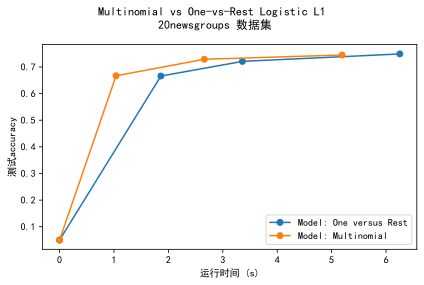

In [2]:
# 在文本分类问题中使用逻辑回归的两种方式进行对比
# one vs rest OVR逻辑回归
# 多项式逻辑回归
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
t0 = timeit.default_timer()

# 选择优化算法
solver = 'saga'

# Turn down for faster run time
n_samples = 10000

X, y = fetch_20newsgroups_vectorized(subset='all', return_X_y=True)
X = X[:n_samples]
y = y[:n_samples]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.1)
train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]

print('20newsgroup数据集, 训练样本数=%i, 特征数=%i, 标签数=%i' % (train_samples, n_features, n_classes))
print('=' * 60)

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 2, 4]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}

for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] 最大迭代次数: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                penalty='l1',  # 想要获得具有最有影响力的特征使用l1，想要最好的分类准确率使用l2
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = timeit.default_timer()
        lr.fit(X_train, y_train)
        train_time = timeit.default_timer() - t1

        y_pred = lr.predict(X_test)
        
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    print('%s 模型测试集的 accuracy: %.4f' % (model, accuracies[-1]))
    print('%% %s模型的非零系数:\n %s' % (model, densities[-1]))
    print('%s 模型的运行时间(%i次迭代): %.2f s' % (model, model_params['iters'][-1], times[-1]))
    print('=' * 60)

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o', label='Model: %s' % name)
    ax.set_xlabel('运行时间 (s)')
    ax.set_ylabel('测试accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n %s 数据集' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = timeit.default_timer() - t0
print('样本运行总时间 %.3f s' % run_time)
plt.show()